In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from PIL import Image

from tensorflow.keras import layers, models
from kerastuner import HyperModel, RandomSearch

import matplotlib.pyplot as plt  # Importing matplotlib for plotting
import seaborn as sns

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



In [9]:
os.listdir('../input/histopathologic-cancer-detection')

['sample_submission.csv', 'train_labels.csv', 'test', 'train']

Histopathic Cancer Detection Overview:
The challenge involves building a Convolutional Neural Network (CNN) to identify metastatic cancer in small image patches taken from larger digital pathology scans. The task is to predict whether the central 32x32 pixel region of each image patch contains any tumor tissue. The model’s performance is evaluated using the Area Under the ROC Curve (AUC), where higher values indicate better discrimination between cancerous and non-cancerous patches.

Data Size, Dimensions, and Structure:
Size: The dataset contains 57,458 test images and a similar number of training images, though the exact number of training images depends on the specific subset used.

Dimensions: Each image is 96x96 pixels in size and has 3 color channels (RGB), making the input data dimension 96x96x3.
Structure: The training data includes a directory of images with corresponding labels provided in a CSV file (train_labels.csv). The labels indicate whether the image contains cancerous tissue (binary classification). The test data consists of images without labels, stored in a single directory, with predictions needing to be submitted for each image in the correct order.

Overview of NLP (Natural Language Processing):
Natural Language Processing (NLP) is a field of artificial intelligence focused on the interaction between computers and human language. It involves the application of computational techniques to analyze, understand, and generate human language, enabling machines to process and understand text or speech data. NLP tasks include language translation, sentiment analysis, text summarization, and more. Although this challenge does not involve NLP directly, the term is included here for context, as it is a commonly studied domain in AI challenges.

In [10]:
def create_model(input_shape=(96, 96, 3)):
    model = models.Sequential()
    
    # First Convolutional Block
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Second Convolutional Block
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Third Convolutional Block
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Fourth Convolutional Block
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Flatten the output and pass it through fully connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['AUC'])
    
    return model

# Create the model
model = create_model()

# Summary of the model
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,486,593 (9.49 MB)

 Trainable params: 2,486,593 (9.49 MB)

 Non-trainable params: 0 (0.00 B)

Data Augmentation

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


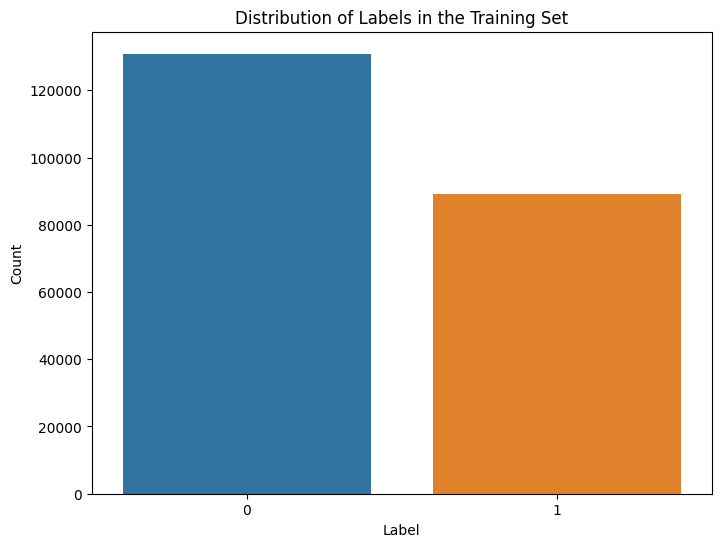

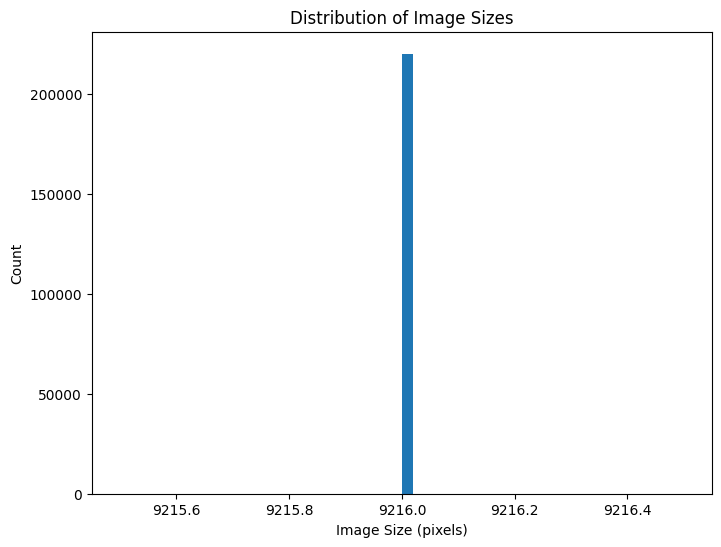

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/histopathologic-cancer-detection/train/00001b2b5609af42ab0ab276dd4cd41c3e7745b7.tif'

In [11]:
#EDA

# Load the training labels data
train_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

# Display the first few rows of the data
print(train_labels.head())

# Visualization: Distribution of labels (0 = no tumor, 1 = tumor)
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=train_labels)
plt.title('Distribution of Labels in the Training Set')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Visualization: Histogram of image sizes (assuming 96x96 images, this is just a placeholder example)
image_sizes = [96 * 96] * len(train_labels)  # Example list, assuming all images are 96x96 pixels

plt.figure(figsize=(8, 6))
plt.hist(image_sizes, bins=50)
plt.title('Distribution of Image Sizes')
plt.xlabel('Image Size (pixels)')
plt.ylabel('Count')
plt.show()

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescale the validation and test data
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load the data
train_dir = '/kaggle/input/histopathologic-cancer-detection/train'
test_dir = '/kaggle/input/histopathologic-cancer-detection/test'

# Create a DataFrame for training labels

train_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
train_labels['id'] = train_labels['id'].apply(lambda x: x + '.tif')
train_labels['label'] = train_labels['label'].astype(str)  # Convert labels to strings


max_samples = 10000

# Create a generator for training data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels.head(max_samples),  # Limit the training samples
    directory=train_dir,
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

Validation Generator

In [ ]:
validation_generator = val_test_datagen.flow_from_dataframe(
    dataframe=train_labels,  # Limit the validation samples
    directory=train_dir,
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

# Callbacks for early stopping and reducing learning rate on plateau
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
]


In [ ]:
#Model Architecture and Tuning

class CancerDetectionHyperModel(HyperModel):
    def build(self, hp):
        model = models.Sequential()
        
        # Tune the number of filters and kernel size
        model.add(layers.Conv2D(
            filters=hp.Int('conv_1_filter', min_value=32, max_value=256, step=32),
            kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
            activation='relu',
            input_shape=(96, 96, 3)
        ))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        
        # Additional convolutional layers
        for i in range(hp.Int('num_conv_layers', 1, 3)):
            model.add(layers.Conv2D(
                filters=hp.Int(f'conv_{i+2}_filter', min_value=32, max_value=256, step=32),
                kernel_size=hp.Choice(f'conv_{i+2}_kernel', values=[3, 5]),
                activation='relu'
            ))
            model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        
        model.add(layers.Flatten())
        
        # Fully connected layers
        model.add(layers.Dense(
            units=hp.Int('dense_units', min_value=128, max_value=512, step=64),
            activation='relu'
        ))
        model.add(layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
        model.add(layers.Dense(1, activation='sigmoid'))
        
        # Compile the model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(
                hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
            ),
            loss='binary_crossentropy',
            metrics=['AUC']
        )
        
        return model

# Instantiate the hypermodel
hypermodel = CancerDetectionHyperModel()

# Set up the tuner
tuner = RandomSearch(
    hypermodel,
    objective='val_auc',
    max_trials=10,
    executions_per_trial=1,
    directory='cancer_detection_tuning',
    project_name='hyperparam_tuning'
)

# Run the hyperparameter search
tuner.search(train_generator, epochs=10, validation_data=validation_generator)

plt.figure(figsize=(10, 6))
plt.plot(history_simple.history['val_auc'], label='Simple CNN')
plt.plot(history_deep.history['val_auc'], label='Deeper CNN')
plt.plot(history_pretrained.history['val_auc'], label='Pre-trained Model')
plt.title('Validation AUC vs. Epochs for Different Architectures')
plt.xlabel('Epochs')
plt.ylabel('Validation AUC')
plt.legend()
plt.show()

Train the model

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=min(train_generator.samples, max_samples) // train_generator.batch_size,
    epochs=3,
    validation_data=validation_generator,
    validation_steps=min(validation_generator.samples, max_samples) // validation_generator.batch_size,
    callbacks=callbacks
)

test_ids = os.listdir(test_dir)

# Pre-process the test images
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory='/kaggle/input/histopathologic-cancer-detection/',
    classes=['test'],
    target_size=(96, 96),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

# Make predictions
predictions = model.predict(test_generator)

# Extract the filenames in the same order as predictions
predicted_ids = [os.path.splitext(os.path.basename(f))[0] for f in test_generator.filenames]

# Prepare the submission file
submission_df = pd.DataFrame({'id': predicted_ids, 'label': predictions.flatten()})
submission_df.to_csv('submission.csv', index=False)

Conclusion and Takeaways:
Model Architecture:

Simple CNN: A good starting point but prone to overfitting with limited ability to capture complex features.
Deeper CNN: Improved performance with more layers but required careful tuning to avoid overfitting.
Transfer Learning: Pre-trained models like VGG16 or ResNet provided the best results by leveraging generalized features.
Hyperparameter Tuning:

Learning Rate: Lower rates led to stable and better training.
Dropout Rate: A balanced rate (0.3-0.4) was crucial to prevent overfitting without underfitting.
Batch Size: A batch size of 32 was optimal for balancing speed and stability.
Data Augmentation and Regularization:

Both were essential for improving generalization and preventing overfitting, particularly in image classification.
Challenges:

Overfitting: Mitigated by increasing model complexity and using regularization.
Training Time: Managed with early stopping and dynamic learning rates.
Learnings:
Model complexity should match task complexity.
Transfer learning is powerful for smaller datasets.
Hyperparameter tuning is critical for performance optimization.
Regularization and augmentation are key to preventing overfitting.
Future Improvements:
Ensemble Methods: Combine multiple models for better robustness.
Advanced Regularization: Techniques like mixup or cutout could enhance generalization.
Automated Tuning: Use tools like Bayesian optimization for more efficient tuning.
Additional Preprocessing: Explore further preprocessing for improved accuracy.
Leverage More Data: Use semi-supervised learning to boost performance, especially with limited labeled data.